In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [72]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 200000 #Your dataset size here. Experiment using smaller values (i.e. 16000), but don't forget to train on at least 160000 to see the best effects
test_portion = .1

corpus = []


In [2]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2021-01-17 08:56:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.31.128, 172.217.2.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   220MB/s    in 1.0s    

2021-01-17 08:56:47 (220 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        pass

In [4]:
row

['4',
 '2193602129',
 'Tue Jun 16 08:40:50 PDT 2009',
 'NO_QUERY',
 'RyanTrevMorris',
 'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ']

In [73]:
num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[row[5], 0 if row[0] == '0' else 1]
        # YOUR CODE HERE
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [74]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [75]:
# shuffle dataset
random.seed(1) # set seed

sentences=[]
labels=[]

random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


# instantiate Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding=padding_type)

In [78]:
# split training set and test set
split = int(test_portion * training_size)

test_sequences = padded[:split]
training_sequences = padded[split:]
test_labels = np.array(labels[:split])
training_labels = np.array(labels[split:])

In [79]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

163202
1


In [80]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt

embeddings_index = {};

with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [81]:
print(len(embeddings_matrix))
# Expected Output
# 138859

163203


In [82]:
embeddings_matrix.shape

(163203, 100)

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPool1D(),
    # tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    # tf.keras.layers.MaxPool1D(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
], name='week3_exercise_question_model')

In [101]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "week3_exercise_question_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 16, 100)           16320300  
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 6, 64)             0         
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 64)                24832     
_________________________________________________________________
flatten_16 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1

In [102]:
num_epochs = 20
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), batch_size=32)

print("Training Complete")

Epoch 1/20
5625/5625 [==============================] - 35s 6ms/step - loss: 0.5887 - accuracy: 0.6792 - val_loss: 0.5122 - val_accuracy: 0.7441
Epoch 2/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.5210 - accuracy: 0.7359 - val_loss: 0.5119 - val_accuracy: 0.7448
Epoch 3/20
5625/5625 [==============================] - 33s 6ms/step - loss: 0.5036 - accuracy: 0.7485 - val_loss: 0.4945 - val_accuracy: 0.7570
Epoch 4/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.4940 - accuracy: 0.7557 - val_loss: 0.4895 - val_accuracy: 0.7620
Epoch 5/20
5625/5625 [==============================] - 32s 6ms/step - loss: 0.4830 - accuracy: 0.7646 - val_loss: 0.4907 - val_accuracy: 0.7588
Epoch 6/20
5625/5625 [==============================] - 33s 6ms/step - loss: 0.4780 - accuracy: 0.7658 - val_loss: 0.4897 - val_accuracy: 0.7613
Epoch 7/20
5625/5625 [==============================] - 31s 6ms/step - loss: 0.4720 - accuracy: 0.7686 - val_loss: 0.4919 - val_ac

<Figure size 432x288 with 0 Axes>

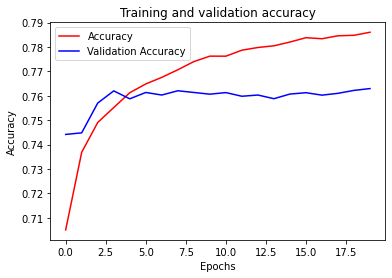

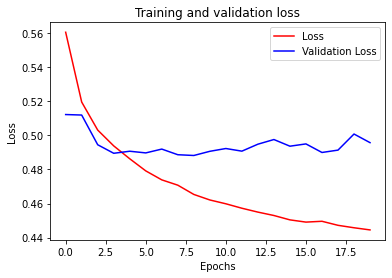

<Figure size 432x288 with 0 Axes>

In [103]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!